The code is based on the paper:
Towards Simulating Foggy and Hazy Images and Evaluating Their Authenticity.
Referenced Github: https://github.com/noahzn/FoHIS

Depth-Anything is based on the paper: Depth Anything: Unleashing the Power of Large-Scale Unlabeled Data
Referenced Github: https://github.com/LiheYoung/Depth-Anything

In [274]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from noise import pnoise3
from transformers import pipeline

In [275]:
# Visibility range of molecules in meters
molecule_visibility = 12
# Visibility range of aerosols in meters
aerosol_visibility = 450
# Coefficients
ECM = 3.912 / molecule_visibility
ECA = 3.912 / aerosol_visibility
# FOG_TOP m
FT = 70
# HAZE_TOP m
HT = 34
# These parameters are set based for road-scenes based images
CAMERA_ALTITUDE = 1.6
fov = 64

In [276]:
img = 'Shift-Dataset/Images/image_34e4-52a5_00000000_img_front.jpg'
Ip = cv2.imread(img)

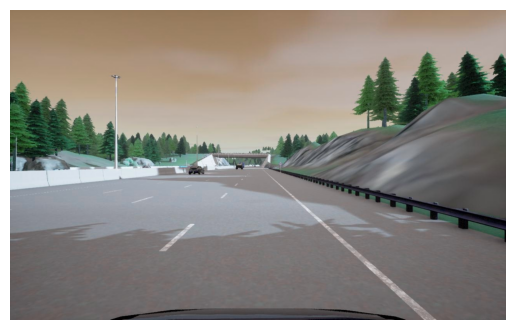

In [277]:
plt.imshow(cv2.cvtColor(Ip, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [278]:
# load pipe
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

image_path = img
image = Image.open(image_path)

# inference
result = pipe(image)
output_d = result["depth"]

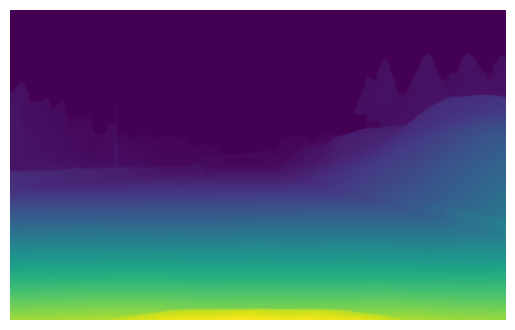

In [279]:
plt.imshow(output_d)
plt.axis('off')
plt.show()

In [280]:
output_d.save("img/result_d.jpg")

In [281]:
depth = cv2.imread('img/result_d.jpg')[:, :, 0].astype(np.float64)
depth[depth==0] = 1
depth *= 3

In [282]:
I = np.empty_like(Ip)
result = np.empty_like(Ip)

In [283]:
def get_image_info(src):
    im = Image.open(src)
    try:
        dpi = im.info['dpi']
    except KeyError:
        dpi = (72, 72)
    return dpi

In [284]:
def elevation_and_distance_estimation(src, depth, vertical_fov, camera_altitude):
    # Load the image and get its DPI
    img = cv2.imread(src)
    img_dpi = get_image_info(src)

    height, width = img.shape[:2]
    altitude = np.empty((height, width))
    distance = np.empty((height, width))
    angle = np.empty((height, width))
    depth_min = depth.min()

    for j in range(width):
        for i in range(height):
            # theta is the vertical angle
            theta = i / (height - 1) * vertical_fov

            # Case: theta is less than half of the vertical FOV
            if theta < 0.5 * vertical_fov:
                distance[i, j] = depth[i, j] / math.cos(math.radians(0.5 * vertical_fov - theta))
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (0.5*height-i)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = camera_altitude+depth[i, j]*y1/depth_min
                angle[i, j] = 0.5 * vertical_fov - theta
            # Case: theta is half of the vertical FOV
            elif theta == 0.5 * vertical_fov:
                distance[i, j] = depth[i, j]
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (i-0.5*height)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = max(camera_altitude - depth[i, j]*y1/depth_min, 0)
                angle[i, j] = 0
            # Case: theta is greater than half of the vertical FOV
            elif theta > 0.5 * vertical_fov:
                distance[i, j] = depth[i, j] / math.cos(math.radians(theta-0.5*vertical_fov))
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (i-0.5*height)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = max(camera_altitude - depth[i, j]*y1/depth_min, 0)
                angle[i, j] = -(theta - 0.5 * vertical_fov)
    return altitude, distance, angle

In [285]:
elevation, distance, angle = elevation_and_distance_estimation(img, depth, fov, CAMERA_ALTITUDE)

In [286]:
def noise(Ip, depth):
    # Initialize three grayscale images
    p1 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    p2 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    p3 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    # Define scales for noise generation
    scales = [1/130.0, 1/60.0, 1/10.0]
    # Generate noise
    for i, scale in enumerate(scales):
        for y in range(Ip.shape[0]):
            for x in range(Ip.shape[1]):
                # Generate Perlin noise
                v = pnoise3(x * scale, y * scale, depth[y, x] * scale, octaves=1, persistence=0.5, lacunarity=2.0)
                color = int((v + (1.2 if i == 2 else (0.5 if i == 1 else 1)))*128)
                if i == 0:
                    p1.putpixel((x, y), color)
                elif i == 1:
                    p2.putpixel((x, y), color)
                elif i == 2:
                    p3.putpixel((x, y), color)
    # Final perlin noise
    perlin = (np.array(p1) + np.array(p2) / 2 + np.array(p3) / 4) / 3
    return perlin

In [287]:
perlin = noise(Ip, depth)
c = (1-elevation/(FT+0.00001))
c[c<0] = 0
ECM = (ECM * c + (1-c)*ECA) * (perlin/255)

In [288]:
distance_through_fog = np.zeros_like(distance)
distance_through_haze = np.zeros_like(distance)
distance_through_haze_free = np.zeros_like(distance)

In [289]:
idx1 = (np.logical_and(FT > elevation, elevation > HT))
idx2 = elevation <= HT
idx3 = elevation >= FT

distance_through_haze[idx2] = distance[idx2]
distance_through_fog[idx1] = (elevation[idx1] - HT) * distance[idx1] / (elevation[idx1] - CAMERA_ALTITUDE)
distance_through_haze[idx1] = distance[idx1] - distance_through_fog[idx1]
distance_through_haze[idx3] = (HT - CAMERA_ALTITUDE) * distance[idx3] / (elevation[idx3] - CAMERA_ALTITUDE)
distance_through_fog[idx3] = (FT - HT) * distance[idx3] / (elevation[idx3] - CAMERA_ALTITUDE)
distance_through_haze_free[idx3] = distance[idx3] - distance_through_haze[idx3] - distance_through_fog[idx3]

I[:, :, 0] = Ip[:, :, 0] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
I[:, :, 1] = Ip[:, :, 1] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
I[:, :, 2] = Ip[:, :, 2] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
O = 1-np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)

In [290]:
Ial = np.empty_like(Ip)
Ial[:, :, 0] = 225
Ial[:, :, 1] = 225
Ial[:, :, 2] = 201

In [291]:
result[:, :, 0] = I[:, :, 0] + O * Ial[:, :, 0]
result[:, :, 1] = I[:, :, 1] + O * Ial[:, :, 1]
result[:, :, 2] = I[:, :, 2] + O * Ial[:, :, 2]

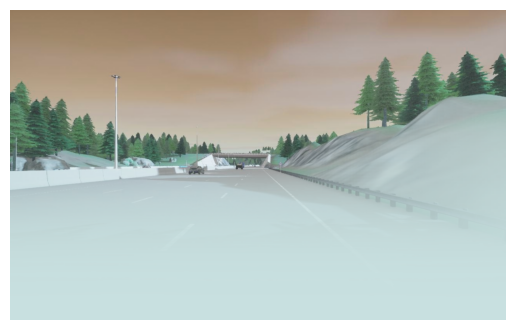

In [292]:
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [293]:
cv2.imwrite('Results/With_Depth-Anything/result.jpg', result)

True